# Career-con-2019 Kaggle Competition

Website of the competition: https://www.kaggle.com/c/career-con-2019

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import scipy.signal 
%matplotlib inline
import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

def load_data(filename):
    return pd.read_csv('./' + filename)

X_train = load_data("X_train.csv")
y_train = load_data("y_train.csv")
X_test = load_data("X_test.csv")

print("Training set data shape: ", X_train.shape)
print("Training set label shape:", y_train.shape)
print("Test set data shape:     ", X_test.shape)

Training set data shape:  (487680, 13)
Training set label shape: (3810, 3)
Test set data shape:      (488448, 13)


***

## Overview

In this Kaggle competition participants should determine the floor surface an unknown robot is standing on, based on data collected by various Inertial Measurement Units (IMU) sensors. 

There are 9 possible **surfaces**: carpet, concrete, fine concrete, hard tiles, hard tiles large space, soft pvc, soft tiles, tiled, wood

The IMU sensors collected 10 different types of data (**channels**):

* **Linear acceleration** along the three axis (3 channels X, Y, Z)


* **Angular velocity** around the three axis (3 channels X, Y, Z)


* **Angular orientation** in quaternionic representation (4 channels X, Y, Z, W)

The training set $X_{\text{train}}$, given as a matrix of dimension (3810 $\times$ 128, 13), consists of 3810 different time series observations, each with 128 measurements; the columns in the matrix represent the data for the 10 channels together with the **time series id** (from 0 to 3809), the **measurement number** (from 0 to 127 for each time series) and the **row id** given as combination of time series id and measurement number:

In [3]:
print("Dimension of X_train: {}; number of train time series: {}/128 = {}".format(X_train.shape, 
        X_train.shape[0], X_train.shape[0]//128))
print()
X_train.head()

Dimension of X_train: (487680, 13); number of train time series: 487680/128 = 3810



,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


The test set $X_{\text{test}}$ is similar, but it contains 3816 time series observations:

In [4]:
print("Dimension of X_test: {}; number of test time series: {}/128 = {}".format(X_test.shape, 
        X_test.shape[0], X_test.shape[0]//128))
print()
X_test.head()

Dimension of X_test: (488448, 13); number of test time series: 488448/128 = 3816



,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


In addition, for the training set we also have the (3810, 3) matrix $y_{\text{train}}$; this contains information about the **surface** (**label**) corresponding to each time series observation, as well as the **time series id** (to match information across X_train and y_train) and the **group id** (from 0 to 72) which indicates the different data recording sessions:

In [11]:
print("Dimension of y_train: {}; number of data recording sessions: {}".format(y_train.shape, 
                                                                               len(y_train['group_id'].unique())))
print()
y_train.head()

Dimension of y_train: (3810, 3); number of data recording sessions: 73



,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


To better match dimensions between $X_{\text{train}}$ and $y_{\text{train}}$ I prefer to define 10 new matrices (one per channel) of dimension (3810, 128) containing a whole time series observation per row:

In [97]:
X_train_acc_X = X_train[['linear_acceleration_X']].values.reshape(3810,-1)
X_train_acc_Y = X_train[['linear_acceleration_Y']].values.reshape(3810,-1)
X_train_acc_Z = X_train[['linear_acceleration_Z']].values.reshape(3810,-1) 
X_train_ang_X = X_train[['angular_velocity_X']].values.reshape(3810,-1)
X_train_ang_Y = X_train[['angular_velocity_Y']].values.reshape(3810,-1)
X_train_ang_Z = X_train[['angular_velocity_Z']].values.reshape(3810,-1)
X_train_ori_X = X_train[['orientation_X']].values.reshape(3810,-1)
X_train_ori_Y = X_train[['orientation_Y']].values.reshape(3810,-1)
X_train_ori_Z = X_train[['orientation_Z']].values.reshape(3810,-1)
X_train_ori_W = X_train[['orientation_W']].values.reshape(3810,-1)

print("Shape 'linear_acceleration_X' matrix (as well as all others):", X_train_acc_X.shape)

Shape 'linear_acceleration_X' matrix (as well as all others): (3810, 128)


***

## A quick glance at the data

In order to familiarize a bit with the problem and have an idea on the data we are dealing with, it may be good to have a quick look at them. 

To do so, let us first define a few convenient objects. Let us create a sorted list of all possible terrains, as well as a dictionary from terrains to integers (since there exist models that only work when the classes are labeled by integers) and a function that returns the terrain given an integer:

In [30]:
terrains = sorted([terrain for terrain in y_train['surface'].unique()])
print("Possible terrains:\n{}".format(terrains))
print()

terrains_dict = {terrain:idx for idx, terrain in enumerate(terrains)}
print("Terrains dictionary:\n{}".format(terrains_dict))

def get_key(val): 
    for key, value in terrains_dict.items():
        if val == value:
            return key
    raise ValueError("key doesn't exist")

Possible terrains:
['carpet', 'concrete', 'fine_concrete', 'hard_tiles', 'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled', 'wood']

Terrains dictionary:
{'carpet': 0, 'concrete': 1, 'fine_concrete': 2, 'hard_tiles': 3, 'hard_tiles_large_space': 4, 'soft_pvc': 5, 'soft_tiles': 6, 'tiled': 7, 'wood': 8}


Let us then create lists containing the series id of all observations relative to a specific terrain, and another list containing the series id of the first observation for each kind of terrain: 

In [34]:
fine_concrete_idx = y_train[y_train['surface'] == 'fine_concrete']['series_id'].values.tolist()
concrete_idx = y_train[y_train['surface'] == 'concrete']['series_id'].values.tolist()
soft_tiles_idx = y_train[y_train['surface'] == 'soft_tiles']['series_id'].values.tolist()
tiled_idx = y_train[y_train['surface'] == 'tiled']['series_id'].values.tolist()
soft_pvc_idx = y_train[y_train['surface'] == 'soft_pvc']['series_id'].values.tolist()
hard_tiles_large_space_idx = y_train[y_train['surface'] == 'hard_tiles_large_space']['series_id'].values.tolist()
carpet_idx = y_train[y_train['surface'] == 'carpet']['series_id'].values.tolist()
hard_tiles_idx = y_train[y_train['surface'] == 'hard_tiles']['series_id'].values.tolist()
wood_idx = y_train[y_train['surface'] == 'wood']['series_id'].values.tolist()

first_idx = [y_train[y_train['surface'] == terrains[i]].iloc[:1]['series_id'].values[0] for i in range(len(terrains))]
print("Index of first example for each different terrain:", first_idx)
y_train.iloc[first_idx]

Index of first example for each different terrain: [12, 1, 0, 27, 8, 6, 4, 5, 39]


,series_id,group_id,surface
12,12,25,carpet
1,1,31,concrete
0,0,13,fine_concrete
27,27,27,hard_tiles
8,8,33,hard_tiles_large_space
6,6,34,soft_pvc
4,4,22,soft_tiles
5,5,1,tiled
39,39,23,wood


It is now easy to plot the data in the various channels for the first observation for each type of terrain:

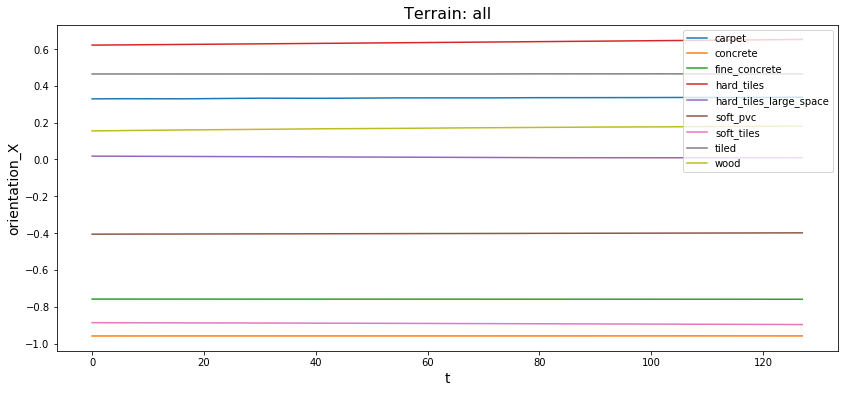

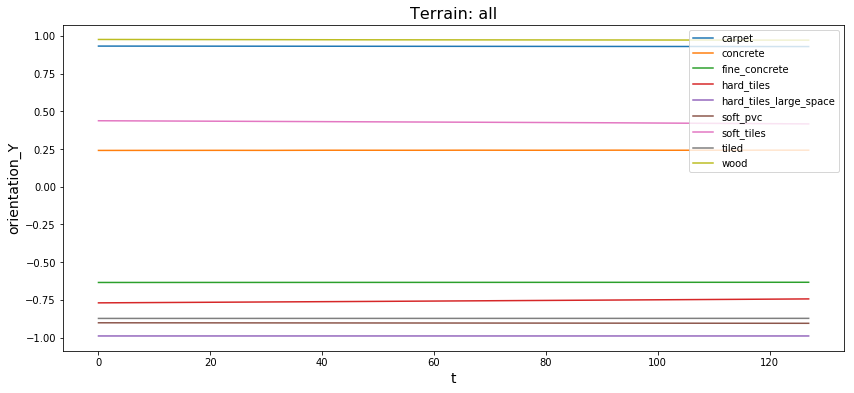

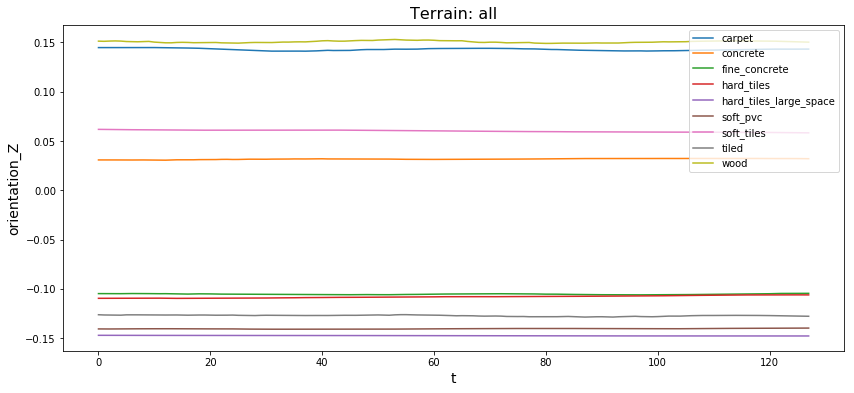

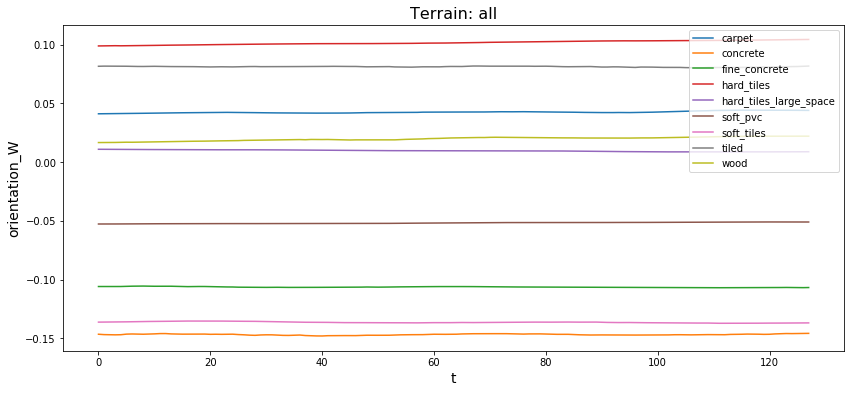

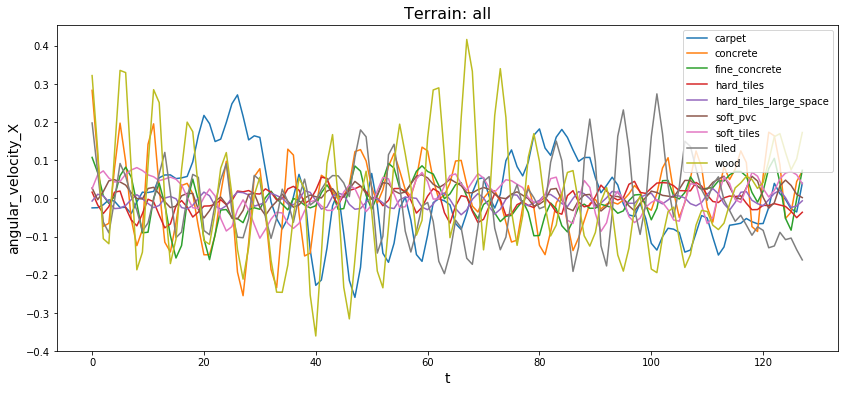

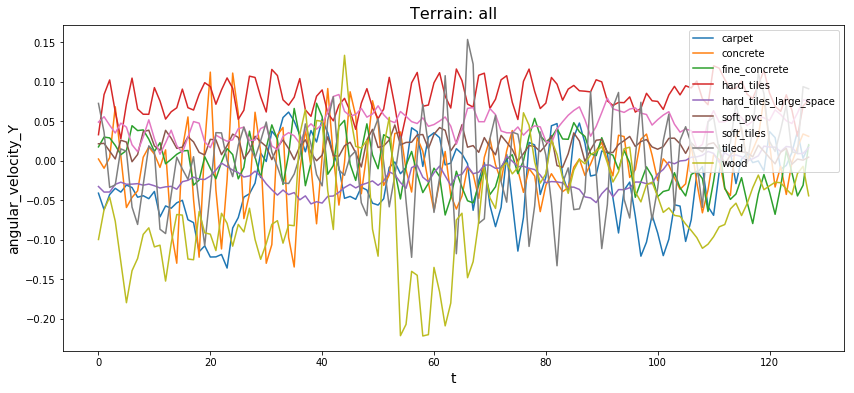

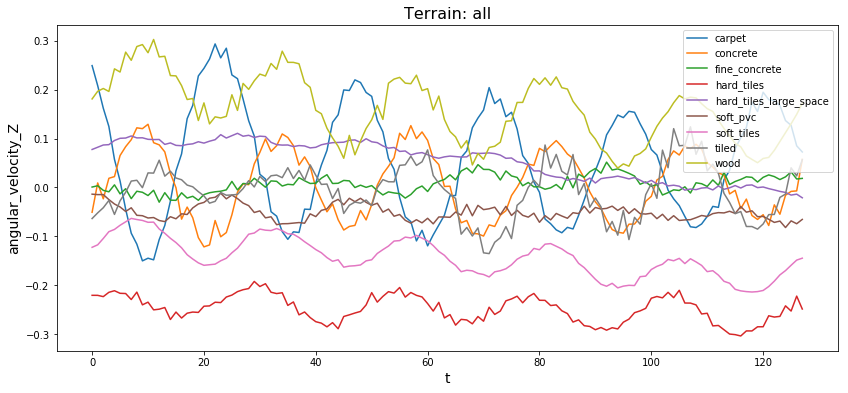

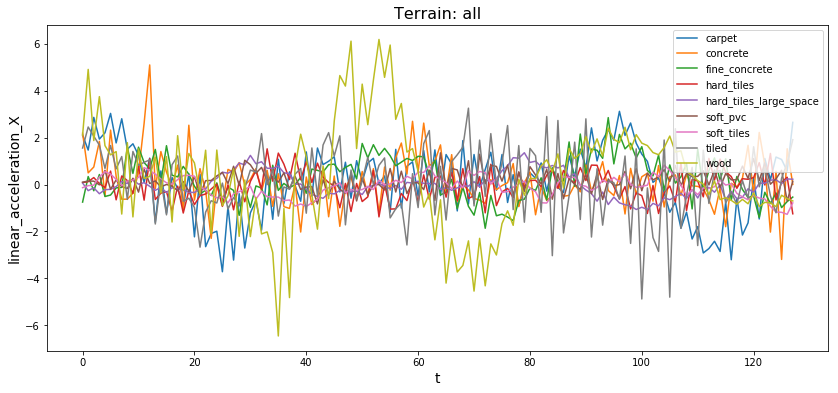

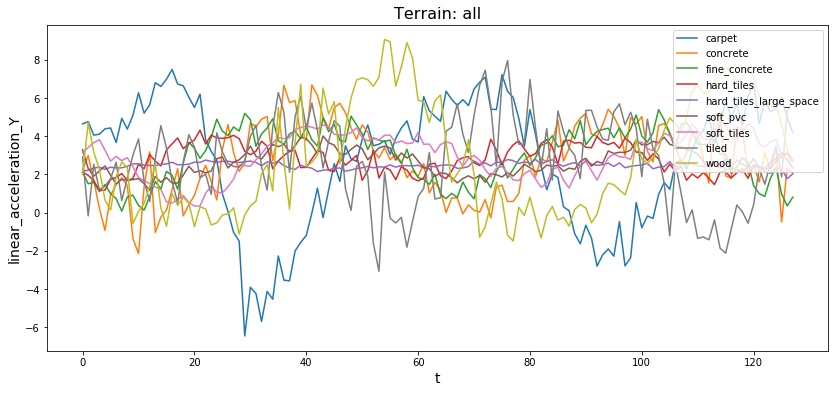

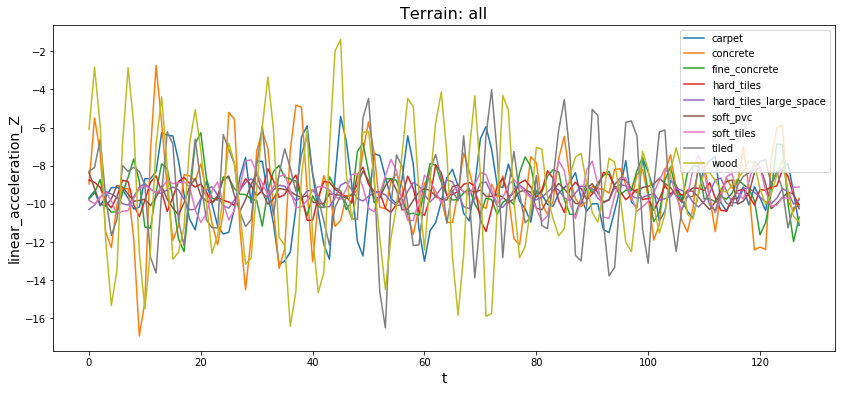

In [98]:
for suff, name in zip(["ori_X", "ori_Y", "ori_Z", "ori_W", "ang_X", "ang_Y", "ang_Z", "acc_X", "acc_Y", "acc_Z"], 
                      list(X_train.columns[3:])):
    plt.figure(figsize = (14,6))
    for i in first_idx:
        plt.plot(eval("X_train_" + suff)[i], label = y_train['surface'][i])
    plt.xlabel('t', fontsize = 14)
    plt.ylabel(name, fontsize = 14)
    plt.legend(loc = 'upper right')
    plt.title('Terrain: all', fontsize = 16)
    plt.show()

We notice that the Y axis accelerations tend to oscillate around the value 2.5 (with oscillations due to friction), while the Z axis accelerations seem to oscillate around the value -9.5 rather than the expected ~ -9.8 due to gravity. The most likely interpretation of this is that the robot is actually moving on a tilted surface: indeed we have

In [87]:
print(round(-np.sqrt(X_train_acc_Z.mean()**2 + X_train_acc_Y.mean()**2), 3))

-9.8


and the numbers are compatible with an inclination of ~ -15 degrees. We will therefore remove this contribution likely due to gravity from the data:

In [99]:
X_train_acc_Y = X_train_acc_Y + np.sqrt(X_train_acc_Z.mean()**2 + X_train_acc_Y.mean()**2)*np.sin(-15*np.pi/180)
X_train_acc_Z = X_train_acc_Z + np.sqrt(X_train_acc_Z.mean()**2 + X_train_acc_Y.mean()**2)*np.cos(-15*np.pi/180)

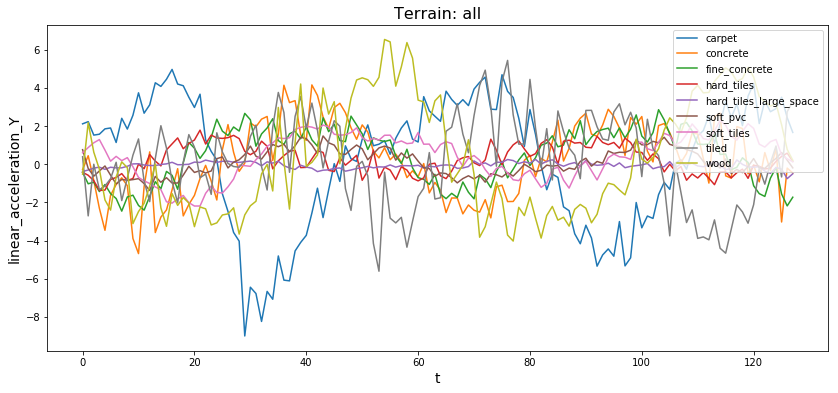

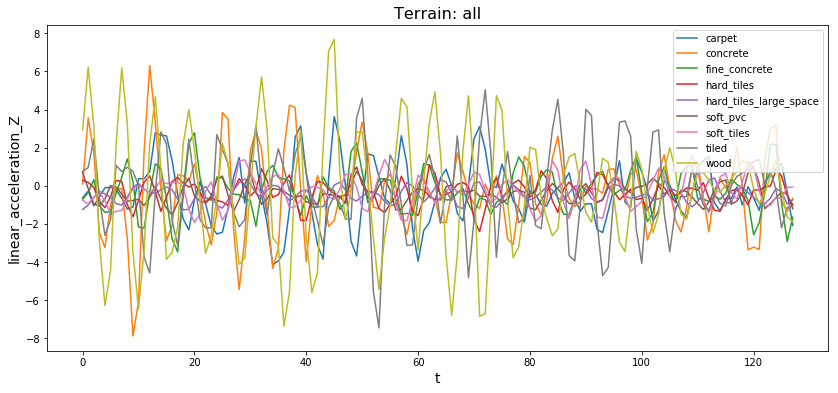

In [101]:
plt.figure(figsize = (14,6))
for i in first_idx:
    plt.plot(X_train_acc_Y[i], label = y_train['surface'][i])
plt.xlabel('t', fontsize = 14)
plt.ylabel("linear_acceleration_Y", fontsize = 14)
plt.legend(loc = 'upper right')
plt.title('Terrain: all', fontsize = 16)
plt.show()

plt.figure(figsize = (14,6))
for i in first_idx:
    plt.plot(X_train_acc_Z[i], label = y_train['surface'][i])
plt.xlabel('t', fontsize = 14)
plt.ylabel("linear_acceleration_Z", fontsize = 14)
plt.legend(loc = 'upper right')
plt.title('Terrain: all', fontsize = 16)
plt.show()

Finally, let us count the number of observations we have for each surface:

In [31]:
y_train['surface'].value_counts().sort_index()

carpet                    189
concrete                  779
fine_concrete             363
hard_tiles                 21
hard_tiles_large_space    308
soft_pvc                  732
soft_tiles                297
tiled                     514
wood                      607
Name: surface, dtype: int64

As we can see there are very few measurements for hard tiles, while we have a lot of measurements for concrete and soft pvc; we should therefore be careful since we are dealing with an imbalanced dataset.

***

## Literature investigation and feature engineering

Before starting analyzing the data, it may be helpful to look for literature discussing the problem, since this can give us ideas about which features and models are best suited for the task. Here there are some relevant papers one can find on the web: 

* https://pdfs.semanticscholar.org/9545/4071449e23d086d3dc290a9d36226e6efb9a.pdf


* https://www.researchgate.net/publication/254672013_Fundamentals_and_Methods_of_Terrain_Classification_Using_Proprioceptive_Sensors


* https://ac.els-cdn.com/S1877705812026537/1-s2.0-S1877705812026537-main.pdf?_tid=e0b2cf85-4a48-42d7-b24c-464bee9b0690&acdnat=1552722591_571fd2417f38ebe603e3aa5d8104ad46


* https://vtechworks.lib.vt.edu/bitstream/handle/10919/75181/Terrain%20Classification.pdf?sequence=1


* https://pdfs.semanticscholar.org/f8e2/2dfa40edf24bdbc8a047f17fcee2ca05350f.pdf


* http://www.carlandmelodee.com/Business/Papers/Freq_Response_Method.pdf


* https://www.researchgate.net/profile/Holger_Froehlich2/publication/221063478_Vibration-based_Terrain_Classification_Using_Support_Vector_Machines/links/09e415093df3777543000000.pdf


* https://pdfs.semanticscholar.org/eb07/e4cf4773319342f411e6eba9114cfc006577.pdf


* http://fsu.digital.flvc.org/islandora/object/fsu:180355/datastream/PDF/view


* https://www.researchgate.net/publication/331603183_Comparative_Study_of_Different_Methods_in_Vibration-Based_Terrain_Classification_for_Wheeled_Robots_with_Shock_Absorbers


* http://www.alexandrevicente.com/publications/Alexandre_Vicente_IROS2015_Final.pdf

After going through the literature, we realize that there are mainly two kind of features used for terrain classification in robotics:

* **Frequency-domain features**, i.e. location and amplitudes of the peaks either in the **discrete Fourier transform** or in the **log power spectral density** of the time series signal;


* **Time-domain features**, i.e. features that can be constructed in terms of the time series signal itself (such as mean, max, min values).

The main channel considered in the literature is the linear acceleration along the Z axis (which should be less sensitive about how the robot moves on the surface), sometimes in combination with the angular velocities along the X and Y axis; only more rarely all three linear accelerations and angular velocities are considered together, and I found no literature discussing the orientation channels (although I surely have missed many papers).

In addition, the literature provides some indication on which models may be more useful: older papers used either Support Vector Machines with time-domain features or shallow fully connected Neural Networks with frequency-domain features, while more recently Random Forest classifiers, Boosting classifiers and Convolutional/Recurrent Neural Networks started receiving more attention (with either time or frequency domain features).

With these considerations in mind, we will try considering various models trained either with time-domain or with frequency-domain features. 

Frequency-domain features simply correspond to the discrete Fourier transform and the power spectral density for the data in our channels (including also the orientation channels for completeness); these can be computed by using the Fast Fourier Transform function `np.fft.fft` implemented in Numpy and the `signal.welch` function implemented in Scipy:

In [107]:
X_train_acc_X_fft = np.array([ np.abs(np.fft.fft(X_train_acc_X[i]))[0:64] for i in range(X_train_acc_X.shape[0]) ])
X_train_acc_Y_fft = np.array([ np.abs(np.fft.fft(X_train_acc_Y[i]))[0:64] for i in range(X_train_acc_Y.shape[0]) ])
X_train_acc_Z_fft = np.array([ np.abs(np.fft.fft(X_train_acc_Z[i]))[0:64] for i in range(X_train_acc_Z.shape[0]) ])
X_train_ang_X_fft = np.array([ np.abs(np.fft.fft(X_train_ang_X[i]))[0:64] for i in range(X_train_ang_X.shape[0]) ])
X_train_ang_Y_fft = np.array([ np.abs(np.fft.fft(X_train_ang_Y[i]))[0:64] for i in range(X_train_ang_Y.shape[0]) ])
X_train_ang_Z_fft = np.array([ np.abs(np.fft.fft(X_train_ang_Z[i]))[0:64] for i in range(X_train_ang_Z.shape[0]) ])
X_train_ori_X_fft = np.array([ np.abs(np.fft.fft(X_train_ori_X[i]))[0:64] for i in range(X_train_ori_X.shape[0]) ])
X_train_ori_Y_fft = np.array([ np.abs(np.fft.fft(X_train_ori_Y[i]))[0:64] for i in range(X_train_ori_Y.shape[0]) ])
X_train_ori_Z_fft = np.array([ np.abs(np.fft.fft(X_train_ori_Z[i]))[0:64] for i in range(X_train_ori_Z.shape[0]) ])
X_train_ori_W_fft = np.array([ np.abs(np.fft.fft(X_train_ori_W[i]))[0:64] for i in range(X_train_ori_W.shape[0]) ])

# Set 'log = True' to compute the log power spectral density rather than the power spectral density itself

def get_psd(array, nperseg = 128, log = False):
    freqs, psd = scipy.signal.welch(array, nperseg = nperseg)
    if log == False:
        return psd[:,0:64]
    if log == True:
        return 10*np.log10(psd[:,0:64])

X_train_acc_X_psd = get_psd(X_train_acc_X)
X_train_acc_Y_psd = get_psd(X_train_acc_Y)
X_train_acc_Z_psd = get_psd(X_train_acc_Z)
X_train_ang_X_psd = get_psd(X_train_ang_X)
X_train_ang_Y_psd = get_psd(X_train_ang_Y)
X_train_ang_Z_psd = get_psd(X_train_ang_Z)
X_train_ori_X_psd = get_psd(X_train_ori_X)
X_train_ori_Y_psd = get_psd(X_train_ori_Y)
X_train_ori_Z_psd = get_psd(X_train_ori_Z)
X_train_ori_W_psd = get_psd(X_train_ori_W)

(**to be continued**)